In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from datetime import datetime

import tensorflow as tf

if not os.path.exists('facenet'):
    !git clone https://github.com/davidsandberg/facenet --depth=1
        
sys.path.insert(0, './facenet/src')
import align.detect_face
import facenet
import scipy.spatial.distance as distance

In [2]:
model_dir = '/home/sabrine/notebook/reid/20170216-091149/'

In [3]:
# starting a session
tf.reset_default_graph()

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

sess = tf.Session(config=tf_config)

print('loading the detection/alignment network...')
pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
print('done!')

print('loading the embedding network...')
meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
restorer = tf.train.import_meta_graph(os.path.join(model_dir, meta_file))
restorer.restore(sess, os.path.join(model_dir, ckpt_file))
print('done!')

# getting input / output tensors
g = tf.get_default_graph()
images_in = g.get_tensor_by_name('input:0')
phase_train_in = g.get_tensor_by_name('phase_train:0')
embeddings = g.get_tensor_by_name('embeddings:0')


loading the detection/alignment network...
done!
loading the embedding network...
done!


In [4]:
imageRGBpath= "/home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-a_16388083_rgb.jpg"

In [5]:
from IPython.display import Image, display

# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709
             
boxes = []
keypoints = []
images = []
print('detecting faces...')

#display(Image(path))
img = scipy.misc.imread(imageRGBpath)
bbs, kps = align.detect_face.detect_face(img, minsize, 
                                           pnet, rnet, onet, threshold, factor)
kps = np.asarray(kps)
print(kps.shape)
kps = kps.reshape([2,5,-1]).T
if len(kps) != 0:  
    images.append(img)  
    boxes.append(bbs)
    keypoints.append(kps)
print('done!')  

detecting faces...
(10, 1)
done!


In [6]:
print('crop image to face only')
size = 160
margin = 32

faces = []

for img, bbs in zip(images, boxes):
    img_faces = []
    for x0,y0,x1,y1,_ in bbs.astype(np.int32):
        x0 = np.maximum(x0 - margin//2, 0)
        y0 = np.maximum(y0 - margin//2, 0)
        x1 = np.minimum(x1 + margin//2, img.shape[1])
        y1 = np.minimum(y1 + margin//2, img.shape[0])
        img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
 
print('done')

crop image to face only
done


In [7]:
imageDpath = "/home/sabrine/notebook/BIWI_dataset/Training/036/036_000130-b_16388045_depth.pgm"

In [8]:
import re
import numpy

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [9]:
image = read_pgm(imageDpath, byteorder='<')

In [10]:
def rgbToD(y, x):
    return(y*480/960, x*640/1280)

In [11]:
y0d, x0d = rgbToD(y0, x0)
y1d, x1d = rgbToD(y1, x1)

In [12]:
image.shape

(480, 640)

In [13]:
image.shape[0]*image.shape[1]

307200

In [14]:
def floodFill(y,x, image, i, flood_fill = np.zeros(image.shape)):
    temp = image.copy()
    toFill = set()
    toFill.add((y,x))
    jump = False
    while len(toFill) > 0:
        (y, x) = toFill.pop()
        depth = temp[y][x]
        if depth > 27320:
            temp[y][x] = 0
            i = i + 1
            if y > 200 and not jump :
                print(str(i) +  "th operations")
                print("y " + str(y) + " and x " + str(x))
                print(toFill)
                jump = True
            flood_fill[y][x] = depth
            if y != 0 :
                toFill.add(((y-1),x))
            if y != 480:    
                toFill.add(((y+1),x))
            if x != 0 :
                toFill.add((y,(x-1)))
            if x != 640:    
                toFill.add((y,(x+1)))
            if i > 307200:
                return "error"
    print(str(i) + ' iterations')
    return flood_fill

In [15]:
test = floodFill(80, 300, image, 0, np.zeros(image.shape))

1089 iterations


In [16]:
image[(y1d-y0d)/2][(x1d-x0d)/2]

42249

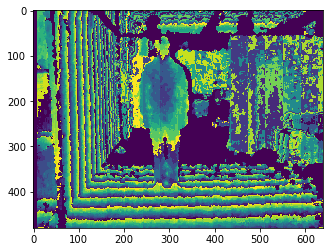

In [17]:
plt.imshow(image)

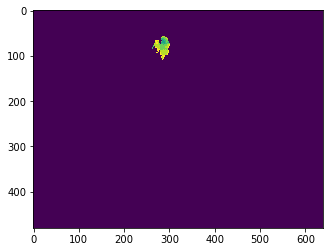

In [18]:
plt.imshow(test)

In [19]:
test.sum()

57863850.0

In [20]:
y0d + (y1d-y0d)/2

107

In [21]:
x0d + (x1d-x0d)/2

291

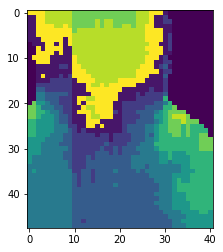

In [22]:
plt.imshow(image[y0d:y1d,x0d:x1d])